In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

In [3]:
tokenizer = Tokenizer()
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt
data = open('/tmp/sonnets.txt').read()

--2019-09-13 16:44:19--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.13.80, 2607:f8b0:4004:808::2010
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.13.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.04s   

2019-09-13 16:44:20 (2.49 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



In [6]:
corpus = data.lower().split("\n")
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

In [11]:
# create input sequences using list of tokens
input_sequences = []
for line in corpus:
    token_list = tokenizer.texts_to_sequences([line])[0]
    for i in range(1, len(token_list)):
        n_gram_sequence = token_list[:i+1]
        input_sequences.append(n_gram_sequence)

In [14]:
len(input_sequences)

15462

In [15]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len,padding='pre'))

predictors, label = input_sequences[:,:-1], input_sequences[:,-1]
label = ku.to_categorical(label, num_classes=total_words)

In [18]:
model = Sequential()
model.add(Embedding(total_words, 100, input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150, return_sequences=True)))
model.add(Dropout(0.2))
model.add(LSTM(100))
model.add(Dense(total_words/2, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 10, 100)           321100    
_________________________________________________________________
bidirectional (Bidirectional (None, 10, 300)           301200    
_________________________________________________________________
dropout (Dropout)            (None, 10, 300)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               160400    
_________________________________________________________________
dense (Dense)                (None, 1605)              162105    
_________________________________________________________________
dense_1 (Dense)              (None, 3211)              5156866   
Total params: 6,101,671
Trainable params: 6,101,671
Non-trainable params: 0
______________________________________________

In [19]:
history = model.fit(predictors, label, epochs=100, verbose=1)

Train on 15462 samples
Epoch 1/100
15462/15462 [==============================] - 43s 3ms/sample - loss: 6.9041 - accuracy: 0.0213
Epoch 2/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 6.4990 - accuracy: 0.0217
Epoch 3/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 6.3987 - accuracy: 0.0236
Epoch 4/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 6.2708 - accuracy: 0.0278
Epoch 5/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 6.1797 - accuracy: 0.0332
Epoch 6/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 6.0948 - accuracy: 0.0393
Epoch 7/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 6.0141 - accuracy: 0.0415
Epoch 8/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 5.9326 - accuracy: 0.0430
Epoch 9/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 5.8419 - accuracy: 0.0493
Epoch

15462/15462 [==============================] - 37s 2ms/sample - loss: 1.5120 - accuracy: 0.7358
Epoch 77/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 1.4821 - accuracy: 0.7423
Epoch 78/100
15462/15462 [==============================] - 38s 2ms/sample - loss: 1.4742 - accuracy: 0.7440
Epoch 79/100
15462/15462 [==============================] - 38s 2ms/sample - loss: 1.4610 - accuracy: 0.7466
Epoch 80/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 1.4420 - accuracy: 0.7507
Epoch 81/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 1.4258 - accuracy: 0.7571
Epoch 82/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 1.3945 - accuracy: 0.7604
Epoch 83/100
15462/15462 [==============================] - 38s 2ms/sample - loss: 1.3789 - accuracy: 0.7639
Epoch 84/100
15462/15462 [==============================] - 37s 2ms/sample - loss: 1.3761 - accuracy: 0.7634
Epoch 85/100
15462/15462 [======

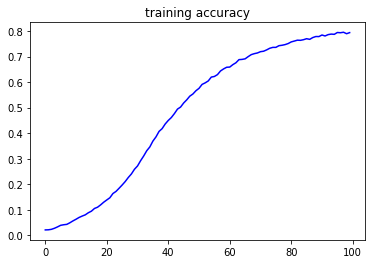

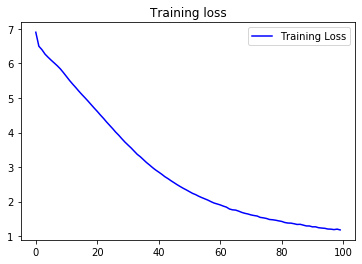

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
loss = history.history['loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('training accuracy')
plt.figure()
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()
plt.show();

In [23]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted = model.predict_classes(token_list, verbose=0)
    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break
    seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope my unkind words old near place twain light twain strife dyed alive me tongue some part ' bearing her end grow dearer brow pride alone mad torn dyed exceeds alive thee dear life young sheds back oppress'd with arising forth arising back some quite free free deem'd back her minds days lies taken torn fled taken abuse me young young days untrue back his store here here now tender'd told thee blushing groan none who tend chide thee here wide sun new rotten pain made ' now his growth ' exchanged young old old cold taken decays grow sad near
